# DLthon - 길찾는 오리들
## Base Settings

In [1]:
# importing the libraries
import keras, tensorflow as tf
from keras import layers

keras.mixed_precision.set_global_policy('mixed_float16')

# importing the modules
import models_base, models_top, utils

2025-01-21 13:34:38.636183: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-21 13:34:38.663335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737434078.680828  324661 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737434078.686113  324661 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 13:34:38.714554: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# loading the dataset
train_dataset, val_dataset, test_dataset = utils.load_unified_datasets("data/data_disruptive_feature_exclusion")

Found 374 files belonging to 6 classes.
Using 225 files for training.
Using 149 files for validation.


I0000 00:00:1737434080.643448  324661 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8931 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
# designing the model
def eV2L_simple2(): # this can be adjusted to be hyper-tunable
    inputs = keras.Input(shape=(224, 224, 3))
    x = utils.image_preprocessing_v1()(inputs) # image preprocessing
    x = models_base.EV2L((224, 224, 3))(x, training=False) # pre-trained model
    x = models_top.simple2()(x) # top model
    outputs = layers.Dense(6, activation='softmax', name="classifier")(x)

    model = keras.Model(inputs, outputs)
    
    model.compile(loss='categorical_crossentropy',
                   optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
                   metrics=['accuracy'])
    
    return model

eV2L_simple2().summary()

2025-01-21 13:34:46.738254: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ image_preprocessing_v1          │ (None, 224, 224, 3)    │             7 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-l (Functional)   │ (None, 7, 7, 1280)     │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ basic_simple2 (Sequential)      │ (None, 256)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,142,125 (450.68 MB)

 Trainable params: 395,270 (1.51 MB)

 Non-trainable params: 117,746,855 (449.17 MB)

In [4]:
# training the model
eV2L_simple2_history = eV2L_simple2().fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[
        utils.callback_savemodel('eV2L_simple2.keras'),
        utils.callback_earlystop(30)
    ],
)

Epoch 1/200


I0000 00:00:1737434122.561305  324783 cuda_dnn.cc:529] Loaded cuDNN version 90600


4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.1469 - loss: 1.8156 - val_accuracy: 0.2656 - val_loss: 1.7672
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.1992 - loss: 1.7919

2025-01-21 13:35:39.444279: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110400 bytes after encountering the first element of size 67110400 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2020 - loss: 1.7903 - val_accuracy: 0.3281 - val_loss: 1.7538
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2271 - loss: 1.7477 - val_accuracy: 0.3281 - val_loss: 1.7451
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3329 - loss: 1.7278 - val_accuracy: 0.3438 - val_loss: 1.7390
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2650 - loss: 1.7368 - val_accuracy: 0.3438 - val_loss: 1.7317
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2683 - loss: 1.7231 - val_accuracy: 0.3594 - val_loss: 1.7241
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3683 - loss: 1.6735 - val_accuracy: 0.4219 - val_loss: 1.7092
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3842 - loss: 1.6928 - val_accuracy: 0.3906 - val_loss: 1.6970
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3829 - loss: 1.6802 - val_accuracy: 0.4062 - val_loss: 1.6906
Epoch 10/200
4/4 ━━━

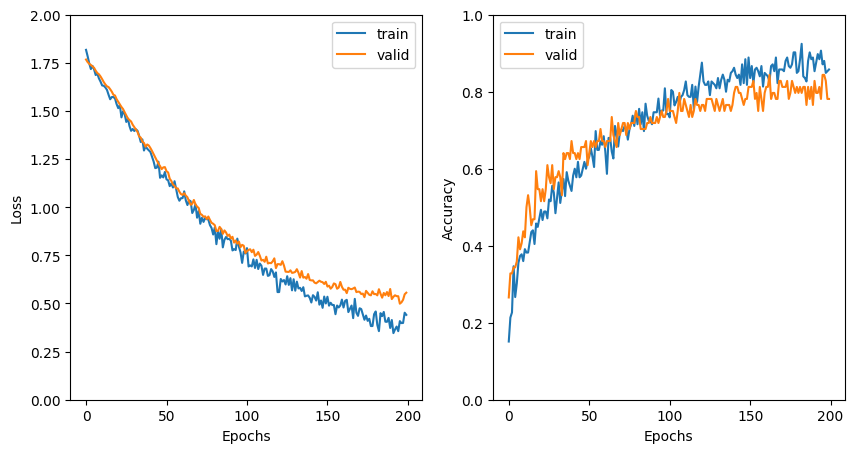

In [5]:
# visualizing the training process
utils.plot_history(eV2L_simple2_history, loss_ylim=(0, 2))

In [6]:
# evaluating the model
test_loss, test_acc = keras.models.load_model('eV2L_simple2.keras').evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}%, Test loss: {test_loss:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step - accuracy: 0.7781 - loss: 0.6187
Test accuracy: 0.78%, Test loss: 0.62


# data_enhanced_0_original_100

In [7]:
# loading the dataset
train_dataset, val_dataset, test_dataset = utils.load_unified_datasets("data/data_enhanced_0_original_100")

# training the model
eV2L_simple2_history = eV2L_simple2().fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[
        utils.callback_savemodel('eV2L_simple2_e00o10.keras'),
        utils.callback_earlystop(30)
    ],
)

Found 374 files belonging to 6 classes.
Using 225 files for training.
Using 149 files for validation.
Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.1373 - loss: 1.8087

2025-01-21 13:45:55.506424: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110400 bytes after encountering the first element of size 67110400 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.1374 - loss: 1.8081 - val_accuracy: 0.2656 - val_loss: 1.7759
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 821ms/step - accuracy: 0.1880 - loss: 1.7802 - val_accuracy: 0.2500 - val_loss: 1.7597
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 813ms/step - accuracy: 0.2387 - loss: 1.7588 - val_accuracy: 0.3594 - val_loss: 1.7484
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 815ms/step - accuracy: 0.2439 - loss: 1.7793 - val_accuracy: 0.4219 - val_loss: 1.7393
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 814ms/step - accuracy: 0.2978 - loss: 1.7410 - val_accuracy: 0.4219 - val_loss: 1.7300
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2733 - loss: 1.6990 - val_accuracy: 0.4375 - val_loss: 1.7226
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 826ms/step - accuracy: 0.3381 - loss: 1.6943 - val_accuracy: 0.4531 - val_loss: 1.7138
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 980ms/step - accuracy: 0.3817 - loss: 1.6883 - val_accuracy: 0.4531 - val_loss: 1.7012
E

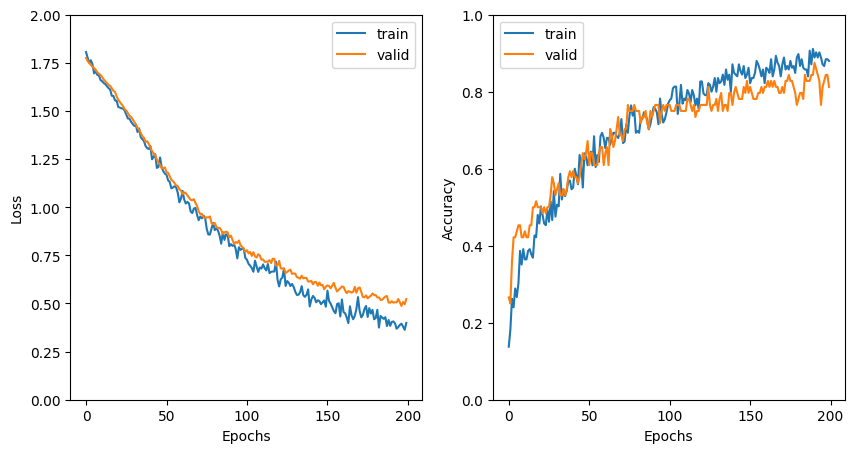

In [8]:
# visualizing the training process
utils.plot_history(eV2L_simple2_history, loss_ylim=(0, 2))

In [9]:
# evaluating the model
test_loss, test_acc = keras.models.load_model('eV2L_simple2_e00o10.keras').evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}%, Test loss: {test_loss:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.8042 - loss: 0.5906
Test accuracy: 0.80%, Test loss: 0.60


# data_enhanced_30_original_70

In [10]:
# loading the dataset
train_dataset, val_dataset, test_dataset = utils.load_unified_datasets("data/data_enhanced_30_original_70")

# training the model
eV2L_simple2_history = eV2L_simple2().fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[
        utils.callback_savemodel('eV2L_simple2_e03o07.keras'),
        utils.callback_earlystop(30)
    ],
)

Found 374 files belonging to 6 classes.
Using 225 files for training.
Using 149 files for validation.
Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.2185 - loss: 1.7775

2025-01-21 13:53:21.642510: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110400 bytes after encountering the first element of size 67110400 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.2184 - loss: 1.7773 - val_accuracy: 0.2500 - val_loss: 1.7724
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.1927 - loss: 1.7668 - val_accuracy: 0.3125 - val_loss: 1.7620
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 833ms/step - accuracy: 0.2806 - loss: 1.7352 - val_accuracy: 0.3125 - val_loss: 1.7504
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 829ms/step - accuracy: 0.2522 - loss: 1.7423 - val_accuracy: 0.2969 - val_loss: 1.7440
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 782ms/step - accuracy: 0.2546 - loss: 1.7151 - val_accuracy: 0.3281 - val_loss: 1.7312
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 787ms/step - accuracy: 0.3792 - loss: 1.6832 - val_accuracy: 0.3750 - val_loss: 1.7268
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 785ms/step - accuracy: 0.3548 - loss: 1.6764 - val_accuracy: 0.3906 - val_loss: 1.7172
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 815ms/step - accuracy: 0.3409 - loss: 1.6552 - val_accuracy: 0.3906 - val_loss: 1.7031
E

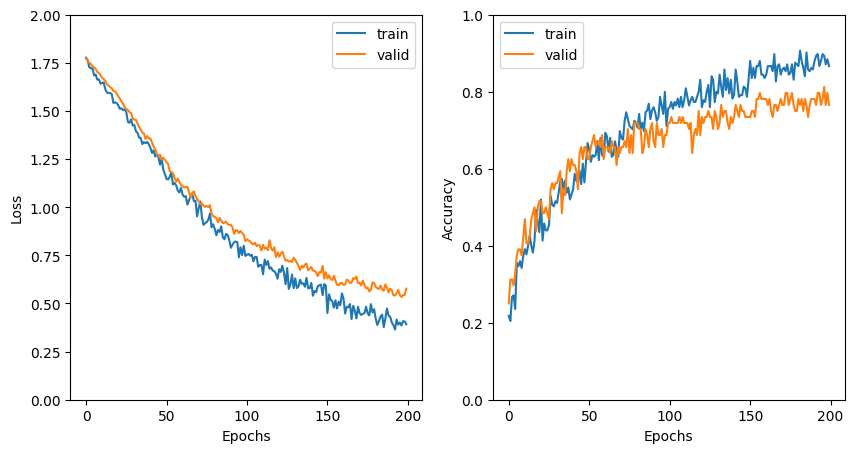

In [11]:
# visualizing the training process
utils.plot_history(eV2L_simple2_history, loss_ylim=(0, 2))

In [12]:
# evaluating the model
test_loss, test_acc = keras.models.load_model('eV2L_simple2_e03o07.keras').evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}%, Test loss: {test_loss:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.7702 - loss: 0.7220
Test accuracy: 0.76%, Test loss: 0.73


# data_enhanced_50_original_50

In [13]:
# loading the dataset
train_dataset, val_dataset, test_dataset = utils.load_unified_datasets("data/data_enhanced_50_original_50")

# training the model
eV2L_simple2_history = eV2L_simple2().fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[
        utils.callback_savemodel('eV2L_simple2_e05o05.keras'),
        utils.callback_earlystop(30)
    ],
)

Found 374 files belonging to 6 classes.
Using 225 files for training.
Using 149 files for validation.
Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.2153 - loss: 1.7930

2025-01-21 14:01:08.340896: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110400 bytes after encountering the first element of size 67110400 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.2158 - loss: 1.7917 - val_accuracy: 0.2812 - val_loss: 1.7645
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 868ms/step - accuracy: 0.2435 - loss: 1.7554 - val_accuracy: 0.2656 - val_loss: 1.7491
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 842ms/step - accuracy: 0.2286 - loss: 1.7660 - val_accuracy: 0.3281 - val_loss: 1.7376
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 826ms/step - accuracy: 0.2908 - loss: 1.7470 - val_accuracy: 0.3438 - val_loss: 1.7296
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 836ms/step - accuracy: 0.2804 - loss: 1.7176 - val_accuracy: 0.3438 - val_loss: 1.7184
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 817ms/step - accuracy: 0.3404 - loss: 1.6966 - val_accuracy: 0.3438 - val_loss: 1.7111
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 813ms/step - accuracy: 0.4107 - loss: 1.6467 - val_accuracy: 0.3594 - val_loss: 1.7079
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 829ms/step - accuracy: 0.3519 - loss: 1.6812 - val_accuracy: 0.3438 - val_loss: 1.693

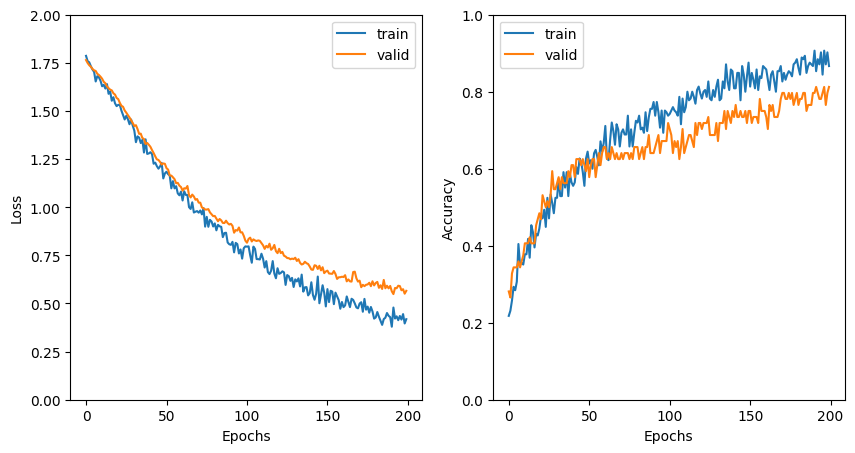

In [14]:
# visualizing the training process
utils.plot_history(eV2L_simple2_history, loss_ylim=(0, 2))

In [15]:
# evaluating the model
test_loss, test_acc = keras.models.load_model('eV2L_simple2_e05o05.keras').evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}%, Test loss: {test_loss:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.7572 - loss: 0.7460
Test accuracy: 0.75%, Test loss: 0.75


# data_enhanced_70_original_30

In [16]:
# loading the dataset
train_dataset, val_dataset, test_dataset = utils.load_unified_datasets("data/data_enhanced_70_original_30")

# training the model
eV2L_simple2_history = eV2L_simple2().fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[
        utils.callback_savemodel('eV2L_simple2_e07o03.keras'),
        utils.callback_earlystop(30)
    ],
)

Found 374 files belonging to 6 classes.
Using 225 files for training.
Using 149 files for validation.
Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.1472 - loss: 1.8384

2025-01-21 14:09:35.506187: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110400 bytes after encountering the first element of size 67110400 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.1479 - loss: 1.8364 - val_accuracy: 0.2344 - val_loss: 1.7789
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2144 - loss: 1.7805 - val_accuracy: 0.2969 - val_loss: 1.7635
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2284 - loss: 1.7760 - val_accuracy: 0.3281 - val_loss: 1.7542
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2001 - loss: 1.7700 - val_accuracy: 0.3594 - val_loss: 1.7509
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2512 - loss: 1.7196 - val_accuracy: 0.3438 - val_loss: 1.7457
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2582 - loss: 1.7237 - val_accuracy: 0.3125 - val_loss: 1.7411
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2880 - loss: 1.6994 - val_accuracy: 0.3594 - val_loss: 1.7332
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3153 - loss: 1.7084 - val_accuracy: 0.3594 - val_loss: 1.7269
Epoch 9/200
4/4 ━━━

2025-01-21 14:20:37.764645: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110400 bytes after encountering the first element of size 67110400 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - accuracy: 0.8567 - loss: 0.4099 - val_accuracy: 0.7188 - val_loss: 0.6821
Epoch 194/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9129 - loss: 0.3705

2025-01-21 14:20:39.517826: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110400 bytes after encountering the first element of size 67110400 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.9116 - loss: 0.3697 - val_accuracy: 0.7656 - val_loss: 0.6791
Epoch 195/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.8873 - loss: 0.3855

2025-01-21 14:20:41.281656: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110400 bytes after encountering the first element of size 67110400 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - accuracy: 0.8859 - loss: 0.3875 - val_accuracy: 0.7500 - val_loss: 0.7037
Epoch 196/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.8571 - loss: 0.4223

2025-01-21 14:20:43.046500: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110400 bytes after encountering the first element of size 67110400 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step - accuracy: 0.8599 - loss: 0.4183 - val_accuracy: 0.7344 - val_loss: 0.6603
Epoch 197/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8779 - loss: 0.3752

2025-01-21 14:20:44.730746: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110400 bytes after encountering the first element of size 67110400 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - accuracy: 0.8766 - loss: 0.3799 - val_accuracy: 0.7344 - val_loss: 0.7052
Epoch 198/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.8848 - loss: 0.3843

2025-01-21 14:20:46.256433: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110400 bytes after encountering the first element of size 67110400 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 388ms/step - accuracy: 0.8803 - loss: 0.3898 - val_accuracy: 0.7500 - val_loss: 0.6987
Epoch 199/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9004 - loss: 0.3902

2025-01-21 14:20:47.745739: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110400 bytes after encountering the first element of size 67110400 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8990 - loss: 0.3910 - val_accuracy: 0.7344 - val_loss: 0.6269
Epoch 200/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 595ms/step - accuracy: 0.8660 - loss: 0.4196 - val_accuracy: 0.7344 - val_loss: 0.6856


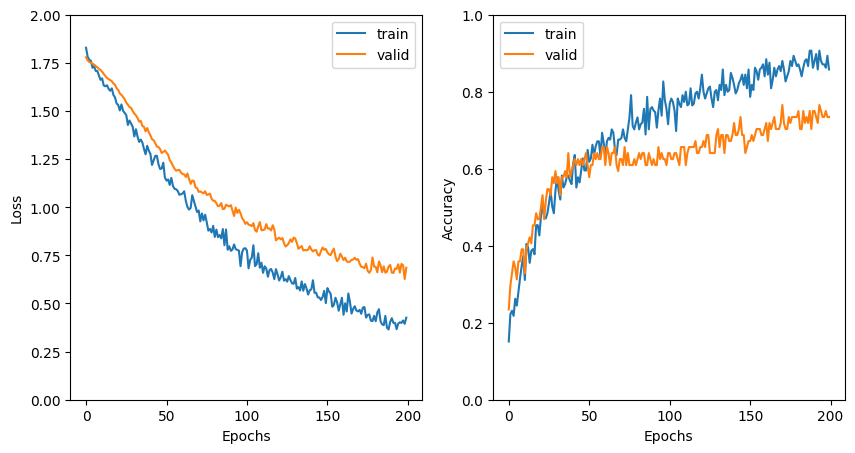

In [17]:
# visualizing the training process
utils.plot_history(eV2L_simple2_history, loss_ylim=(0, 2))

In [18]:
# evaluating the model
test_loss, test_acc = keras.models.load_model('eV2L_simple2_e07o03.keras').evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}%, Test loss: {test_loss:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.6919 - loss: 0.8139
Test accuracy: 0.69%, Test loss: 0.80


# data_enhanced_100_original_0

In [19]:
# loading the dataset
train_dataset, val_dataset, test_dataset = utils.load_unified_datasets("data/data_enhanced_100_original_0")

# training the model
eV2L_simple2_history = eV2L_simple2().fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[
        utils.callback_savemodel('eV2L_simple2_e10o00.keras'),
        utils.callback_earlystop(30)
    ],
)

Found 374 files belonging to 6 classes.
Using 225 files for training.
Using 149 files for validation.
Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.1797 - loss: 1.7828

2025-01-21 14:21:48.107666: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110912 bytes after encountering the first element of size 67110912 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.1802 - loss: 1.7816 - val_accuracy: 0.2969 - val_loss: 1.7664
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2500 - loss: 1.7513 - val_accuracy: 0.3438 - val_loss: 1.7563
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2782 - loss: 1.7413 - val_accuracy: 0.2969 - val_loss: 1.7474
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2554 - loss: 1.7628 - val_accuracy: 0.3125 - val_loss: 1.7410
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3241 - loss: 1.7187 - val_accuracy: 0.3281 - val_loss: 1.7347
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3235 - loss: 1.7004 - val_accuracy: 0.3281 - val_loss: 1.7291
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3543 - loss: 1.6788 - val_accuracy: 0.4062 - val_loss: 1.7227
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3162 - loss: 1.6788 - val_accuracy: 0.4219 - val_loss: 1.7129
Epoch 9/200
4/4 ━━━

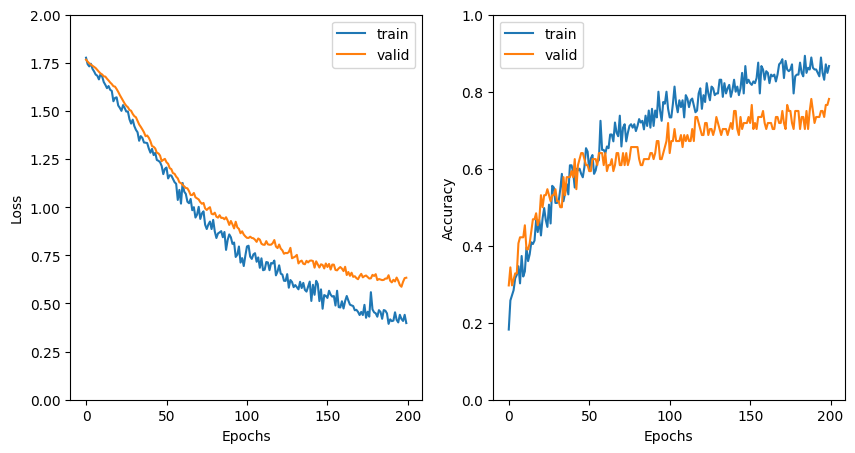

In [20]:
# visualizing the training process
utils.plot_history(eV2L_simple2_history, loss_ylim=(0, 2))

In [21]:
# evaluating the model
test_loss, test_acc = keras.models.load_model('eV2L_simple2_e10o00.keras').evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}%, Test loss: {test_loss:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.7415 - loss: 0.7240
Test accuracy: 0.73%, Test loss: 0.73
